# Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning. (Portafolio Implementación)

Se implemetó Deep Dream haciendo uso de Keras.

### Imagen a modificar

Se eligió una foto de un paisaje capturada en la ciudad de Stavanger, Noruega.

In [1]:
%cd "/content/sample_data/"
!ls  # show current directory

/content/sample_data
anscombe.json		     california_housing_train.csv  mnist_test.csv	  muelle.jpg
california_housing_test.csv  FrankWW.jpg		   mnist_train_small.csv  README.md


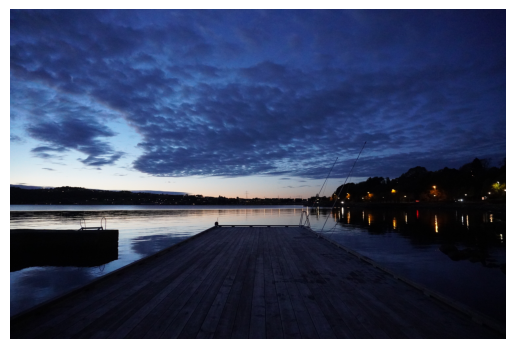

In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = '/content/sample_data/muelle.jpg'


plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

### Se crea un instancia del modelo pre-entrenado `InceptionV3`

A continuación, necesitamos una red neuronal convolucional preentrenada. Se decidió usar Inception debido a que es el modelo utilizado en la primera versión de Deep Dream.

In [3]:
from keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87910968/87910968 [==============================] - 3s 0us/step


### Configuración de las capas de Deep Dream

En esta configuración, se han ajustado los coeficientes de las capas para resaltar características que podrían ser relevantes para una foto de un paisaje nocturno. Así pues, se optó por usar capas de un nivel más bajo para potenciar los patrones geométricos presentes en la imagen de output.



In [29]:
#model.summary()

In [4]:
#layer_settings = {
#    "mixed4": 1.0,
#    "mixed5": 1.5,
#    "mixed6": 2.0,
#    "mixed7": 2.5,
#}

layer_settings = {
    "mixed2": 0.1,
    "mixed3": 0.5,
    "mixed4": 1.5,
    "mixed5": 2.0,
}

# Symbolic outputs of each layer
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

# Model that returns the activation values for every target layer (as a dict)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

### Función de pérdida en Deep Dream

A continuación se define la función de pérdida en Deep Dream, es decir, aquella que se utiliza para cuantificar cuánto se desvía la imagen generada de la imagen original en términos de las activaciones de ciertas capas de la red neuronal.

In [5]:
def compute_loss(input_image):
    # Extract activations.
    features = feature_extractor(input_image)
    # Initialize the loss to 0.
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # Avoid border artifacts by only involving non-border pixels in the loss.
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

### Ascenso de gradiente y octavas.


In [6]:
import tensorflow as tf

# @tf.function decorator optimizes function execution
# by transforming Python code into dataflow graphs.
@tf.function
def gradient_ascent_step(image, learning_rate):
    # Compute gradients of DeepDream loss with respect to the current image.
    with tf.GradientTape() as tape: # GradientTape to record operations for auto-diff
        tape.watch(image) # Instruct tape to keep track of image
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    # Normalize gradients
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image

# Gradient ascent for a given image scale (octave).
def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    # Repeatedly update the image in a way that increases the DeepDream loss.
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        # Break out if the loss crosses a certain threshold
        # (over-optimizing would create unwanted image artifacts).
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

## Parámetros a modificar dependiendo de la imagen.

- step (Tamaño del Paso):

Este parámetro controla el tamaño del paso en el espacio de la imagen durante la optimización.

Un paso más grande hará que los cambios en la imagen sean más notorios en cada iteración, pero puede llevar a resultados más abruptos. Un paso más pequeño puede suavizar los cambios en la imagen.

- num_octave (Número de Octavas):

Determina cuántas veces se aplica el proceso de optimización a imágenes de diferentes escalas.

Un número mayor de octavas permite capturar detalles a diferentes escalas, pero también puede aumentar el tiempo de cálculo.

- octave_scale (Escala de Octava):

Define la proporción de tamaño entre escalas sucesivas.

Un valor mayor amplía las escalas rápidamente, mientras que un valor menor puede capturar detalles más finos a escalas más pequeñas.

- iterations (Número de Iteraciones):

Indica cuántas veces se realiza la optimización en cada escala de octava.

Un número mayor de iteraciones permite cambios más significativos en la imagen, pero también puede aumentar el tiempo de cálculo.

- max_loss (Pérdida Máxima):

Especifica el valor de pérdida en el cual se detiene la optimización para una escala si se supera.

Un valor más alto permite una mayor variabilidad en la imagen generada antes de detener la optimización.

Conociendo lo anterior:

- Un valor de step moderado (15.0) se elige para permitir cambios notorios en la imagen en cada iteración sin que sean demasiado abruptos.

- Al utilizar 5 octavas, se busca capturar detalles a diferentes escalas, lo que puede ser beneficioso para destacar los detalles más finos en la imagen nocturna.

- Una escala de octava de 1.4 se elige para ampliar las escalas de manera moderada. Esto permite que el algoritmo capture detalles finos y patrones más amplios en la imagen de manera efectiva.

- Con 50 iteraciones por escala, se busca permitir cambios más significativos en la imagen generada en cada octava.

-  Se establece una pérdida de 30 para permitir explorar diferentes estilos y patrones sin detener el proceso antes de tiempo.



In [7]:
step = 15. # Gradient ascent step size
num_octave = 5 # Number of scales at which to run gradient ascent
octave_scale = 1.4 # Size ratio between successive scales
iterations = 50 # Number of gradient ascent steps per scale
max_loss = 30. # Stop the gradient ascent process for a scale if the loss gets higher than this.

### Funciones para el procesamiento de imagen

In [8]:
import numpy as np

# Util function to open, resize, and format pictures into appropriate arrays
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # Inception expects images in a particular state
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

# Util function to convert a NumPy array into a valid image
def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    # Undo inception v3 preprocessing.
    img /= 2.0
    img += 0.5
    img *= 255.
    # Convert to uint8 and clip to the valid range [0, 255].
    img = np.clip(img, 0, 255).astype("uint8")
    return img

### Se ejecuta el re escalamiento de la imagen para obtener el resultado final.

In [9]:
# Load the test image.
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

# Compute the target shape of the image at different octaves.
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

# Make a copy of the image (we need to keep the original around).
img = tf.identity(original_img)

# Iterate over the different octaves.
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    # Scale up the dream image.
    img = tf.image.resize(img, shape)
    # Run gradient ascent, altering the dream.
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    # Scale up the smaller version of the original image: it will be pixellated.
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)

    # Compute the high-quality version of the original image at this size.
    same_size_original = tf.image.resize(original_img, shape)
    # The difference between the two is the detail that was lost when scaling up.
    lost_detail = same_size_original - upscaled_shrunk_original_img
    # Re-inject lost detail into the dream.
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

Processing octave 0 with shape (520, 783)
... Loss value at step 0: 0.82
... Loss value at step 1: 1.13
... Loss value at step 2: 1.62
... Loss value at step 3: 2.16
... Loss value at step 4: 2.73
... Loss value at step 5: 3.28
... Loss value at step 6: 3.85
... Loss value at step 7: 4.41
... Loss value at step 8: 4.96
... Loss value at step 9: 5.48
... Loss value at step 10: 6.02
... Loss value at step 11: 6.52
... Loss value at step 12: 7.03
... Loss value at step 13: 7.51
... Loss value at step 14: 7.99
... Loss value at step 15: 8.48
... Loss value at step 16: 8.93
... Loss value at step 17: 9.40
... Loss value at step 18: 9.82
... Loss value at step 19: 10.26
... Loss value at step 20: 10.68
... Loss value at step 21: 11.11
... Loss value at step 22: 11.50
... Loss value at step 23: 11.94
... Loss value at step 24: 12.31
... Loss value at step 25: 12.73
... Loss value at step 26: 13.09
... Loss value at step 27: 13.46
... Loss value at step 28: 13.84
... Loss value at step 29: 14.

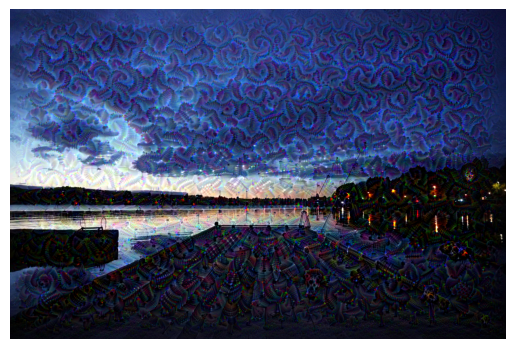

In [10]:
# Display the final result.
plt.axis("off")
plt.imshow(deprocess_image(img.numpy()))

## Prueba con una imagen distinta

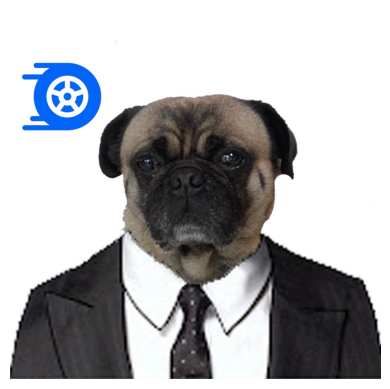

In [11]:
base_image_path = '/content/sample_data/FrankWW.jpg'


plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

In [12]:
layer_settings = {
    "mixed2": 0.1,
    "mixed3": 0.5,
    "mixed4": 1.5,
    "mixed5": 2.0,
}

# Symbolic outputs of each layer
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

# Model that returns the activation values for every target layer (as a dict)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [13]:
step = 15. # Gradient ascent step size
num_octave = 5 # Number of scales at which to run gradient ascent
octave_scale = 1.4 # Size ratio between successive scales
iterations = 50 # Number of gradient ascent steps per scale
max_loss = 40. # Stop the gradient ascent process for a scale if the loss gets higher than this.

In [14]:
# Load the test image.
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

# Compute the target shape of the image at different octaves.
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

# Make a copy of the image (we need to keep the original around).
img = tf.identity(original_img)

# Iterate over the different octaves.
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    # Scale up the dream image.
    img = tf.image.resize(img, shape)
    # Run gradient ascent, altering the dream.
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    # Scale up the smaller version of the original image: it will be pixellated.
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)

    # Compute the high-quality version of the original image at this size.
    same_size_original = tf.image.resize(original_img, shape)
    # The difference between the two is the detail that was lost when scaling up.
    lost_detail = same_size_original - upscaled_shrunk_original_img
    # Re-inject lost detail into the dream.
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

Processing octave 0 with shape (279, 279)
... Loss value at step 0: 1.59
... Loss value at step 1: 1.91
... Loss value at step 2: 2.55
... Loss value at step 3: 2.95
... Loss value at step 4: 3.70
... Loss value at step 5: 4.32
... Loss value at step 6: 5.17
... Loss value at step 7: 6.00
... Loss value at step 8: 6.73
... Loss value at step 9: 7.42
... Loss value at step 10: 8.22
... Loss value at step 11: 8.90
... Loss value at step 12: 9.68
... Loss value at step 13: 10.32
... Loss value at step 14: 11.12
... Loss value at step 15: 11.74
... Loss value at step 16: 12.33
... Loss value at step 17: 13.08
... Loss value at step 18: 13.74
... Loss value at step 19: 14.31
... Loss value at step 20: 15.04
... Loss value at step 21: 15.67
... Loss value at step 22: 16.40
... Loss value at step 23: 17.03
... Loss value at step 24: 17.90
... Loss value at step 25: 18.28
... Loss value at step 26: 19.11
... Loss value at step 27: 19.68
... Loss value at step 28: 20.33
... Loss value at step 2

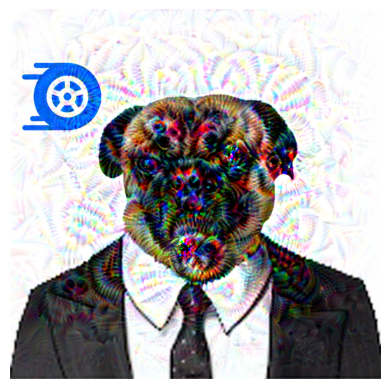

In [15]:
# Display the final result.
plt.axis("off")
plt.imshow(deprocess_image(img.numpy()))